# TDSE Neural network results

Notebook with the basic information how to run and use the TDSE-NN model.

Requirements: [mynumerics](https://github.com/nemectad/mynumerics.git) and [HHGtoolkit](https://github.com/nemectad/HHGtoolkit.git) libraries.

In [1]:
### Load modules

import matplotlib.pyplot as plt
import TDSE_NN as NN
from importlib import reload
import numpy as np
import tensorflow as tf
from numpy.fft import fft, ifft, fftfreq

2023-11-24 10:44:56.454239: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# High intensity fields

Load the dataset for high-intensity field propagation: $I = 10^{14} W/cm^2$

In [74]:
dataset, t = NN.load_fields_from_h5("/Volumes/NEMEC_SSD/1e14_dz=50000/")

The dataset contains 2001 HDF5 files (500 iterations of RK4). The total spatially resolved harmonic spectrum during the propagation is shown in the figure below:


![High-intensity field](./Figures/1e14_ab-initio_full_prop_LQ.png)

Print the shape of the dataset and shuffle randomly

In [75]:
print(dataset.shape)
np.random.shuffle(dataset)
print(dataset.shape)


(2001, 2, 25601)
(2001, 2, 25601)


### Data preprocessing pipeline

The data preprocessing pipeline is depicted in the following figure:

![Data preprocessing pipeline](Figures/Data_prep_pipeline.png)

The data preprocessing is summarized in the following section of the script:

(i) We set an initial size (or the frequency cutoff) of the input (N) and output arrays (M).

(ii) We initialize the temporal filter that enhances some of the low intensity features.

(iii) We invoke the function ```NN.preprocess``` that takes the features and labels for the training and validation, does the frequency cutoff, according to the number set in (i), in the second argument, temporal grid of the original array in the third argument and the last argument corresponds to the $n$-th root of the real and imaginary parts of the spectrum (see the Diploma thesis, however it is set by default to 1).

The input features for the network have the shape `(batch_size, floor(N/2), 2)`, the output labels have the shape `(batch_size, 2*floor(M/2))`.

In [76]:
### Set init size - !!!must be an odd number due to the nature of FFT applied on a real signal!!!
M = 1999
### Set output the same size as the input
N = M

### Initialize temporal filter
f = NN.filter(np.ones((len(t))), t)

### Apply the temporal filter, do the Re and Im separation, apply the phase shift,
### return arrays of the desired shape
xf = np.array([np.transpose(NN.preprocess(f*x, N, t)) for x in dataset[:,0]])
yf = np.array([np.concatenate(NN.preprocess(f*(-y[1]-1*y[0]), M, t), axis = None) for y in dataset])


Print the shape to check the features and labels dimensions.

In [77]:
print(xf.shape)
print(yf.shape)

(2001, 1000, 2)
(2001, 2000)


#### Remark: alternative shuffle of the initial dataset

We can shuffle the dataset given a particular distribution. Here, we use the generation of random integers from a given range according to the exponential distribution. 

**No need to use it once the dataset is shuffled**

[556, 1698, 138, 370, 409, 434, 676, 400, 1944, 810, 1026, 617, 847, 1226, 754, 691, 330, 1936, 846, 1866, 956, 896, 1334, 784, 1681, 1674, 431, 1580, 723, 812, 1141, 1809, 1675, 223, 1287, 317, 1776, 572, 357, 1699, 1789, 481, 1487, 522, 939, 983, 1251, 1948, 1643, 1246, 123, 1645, 1219, 787, 849, 463, 393, 1057, 1644, 317, 1565, 553, 510, 1314, 1162, 1710, 1436, 1674, 250, 108, 445, 1476, 564, 51, 1299, 1217, 714, 603, 1740, 1642, 1343, 928, 786, 1758, 430, 1424, 813, 27, 315, 1085, 325, 1115, 728, 680, 1847, 1246, 1804, 443, 984, 1475, 882, 239, 1678, 1790, 910, 1271, 388, 229, 1193, 653, 1991, 1485, 864, 1658, 1389, 168, 97, 106, 873, 1888, 794, 1443, 73, 54, 1634, 889, 1424, 144, 895, 276, 1329, 3, 1929, 1379, 1565, 1950, 515, 288, 1049, 109, 1148, 855, 1596, 862, 685, 306, 1967, 232, 755, 224, 216, 821, 1583, 1413, 1778, 972, 1800, 908, 833, 406, 96, 1678, 1535, 1857, 1752, 1634, 1237, 897, 608, 1610, 1334, 1822, 198, 701, 1306, 1292, 1530, 676, 1126, 618, 847, 897, 1949, 757, 6,

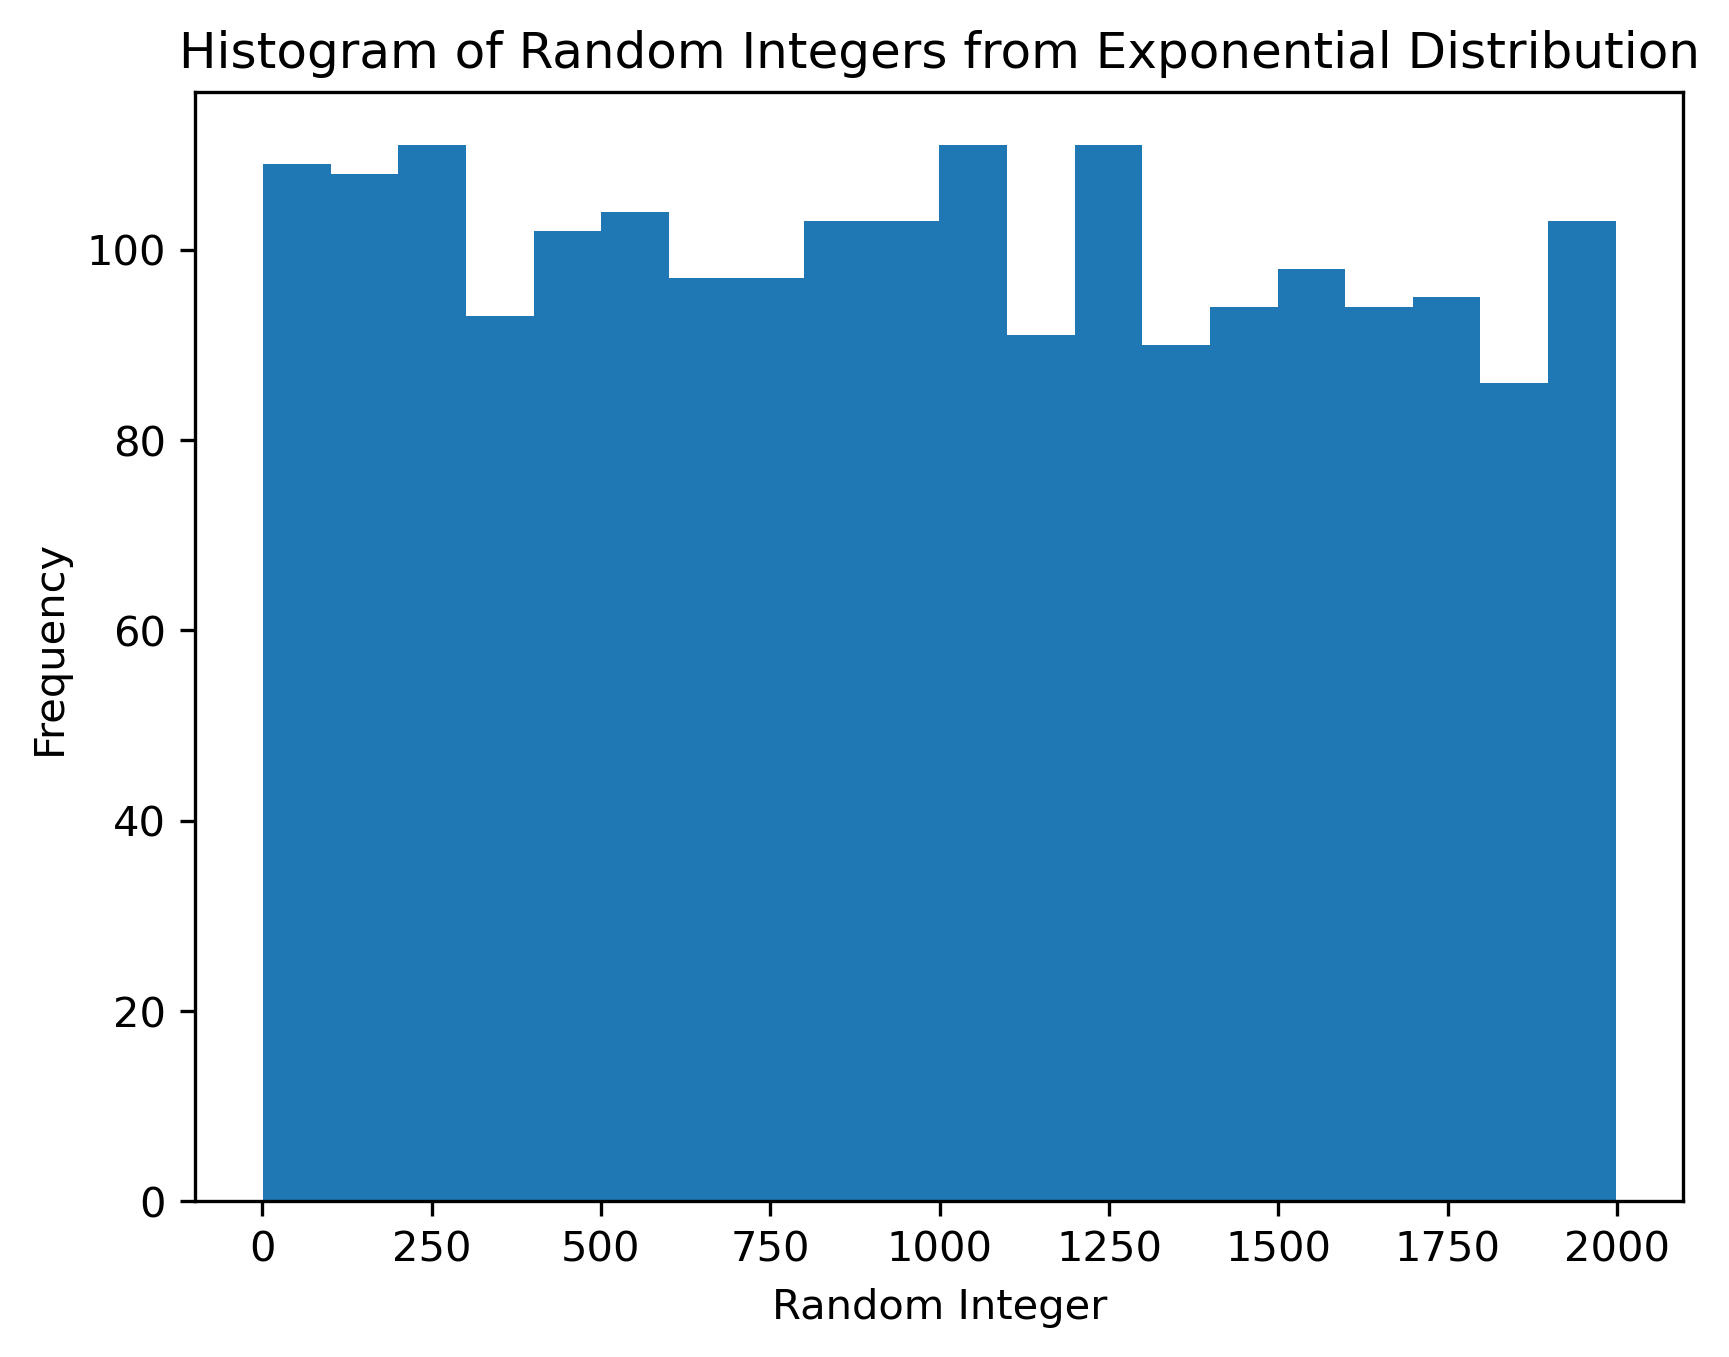

In [15]:
samples = NN.generate_random_integers(4000, lambda_=0.01, max_index=4000)
samples = NN.generate_random_integers(500, lambda_=0.01, max_index=500)
samples = NN.generate_random_integers(2000, lambda_=0.01, max_index=2000)
print(samples)

fig = plt.figure()
fig.dpi = 300
plt.hist(samples, bins=20)
plt.xlabel("Random Integer")
plt.ylabel("Frequency")
plt.title("Histogram of Random Integers from Exponential Distribution")
plt.show()

In [104]:
x_f = xf[samples]
y_f = yf[samples]
print(x_f.shape)
print(y_f.shape)

(2000, 1025, 2)
(2000, 2050)


### Pick training and validation datasets

The datasets are already initially shuffled, therefore we choose the desired ratio of the training and validation data. We pick the ratio 80%/20% for 2000 datasets.

In [78]:

x_train_f, x_test_f = xf[:1600], xf[1600:]
y_train_f, y_test_f = yf[:1600], yf[1600:]

### Min-max normalization

Normalize the input features according to the min-max normalization.

In [79]:
x_train_f, x_test_f = NN.min_max_normalize(x_train_f, x_test_f)

### Remark: see the effect of the convolution layers applied on the data

(1, 1025, 2)


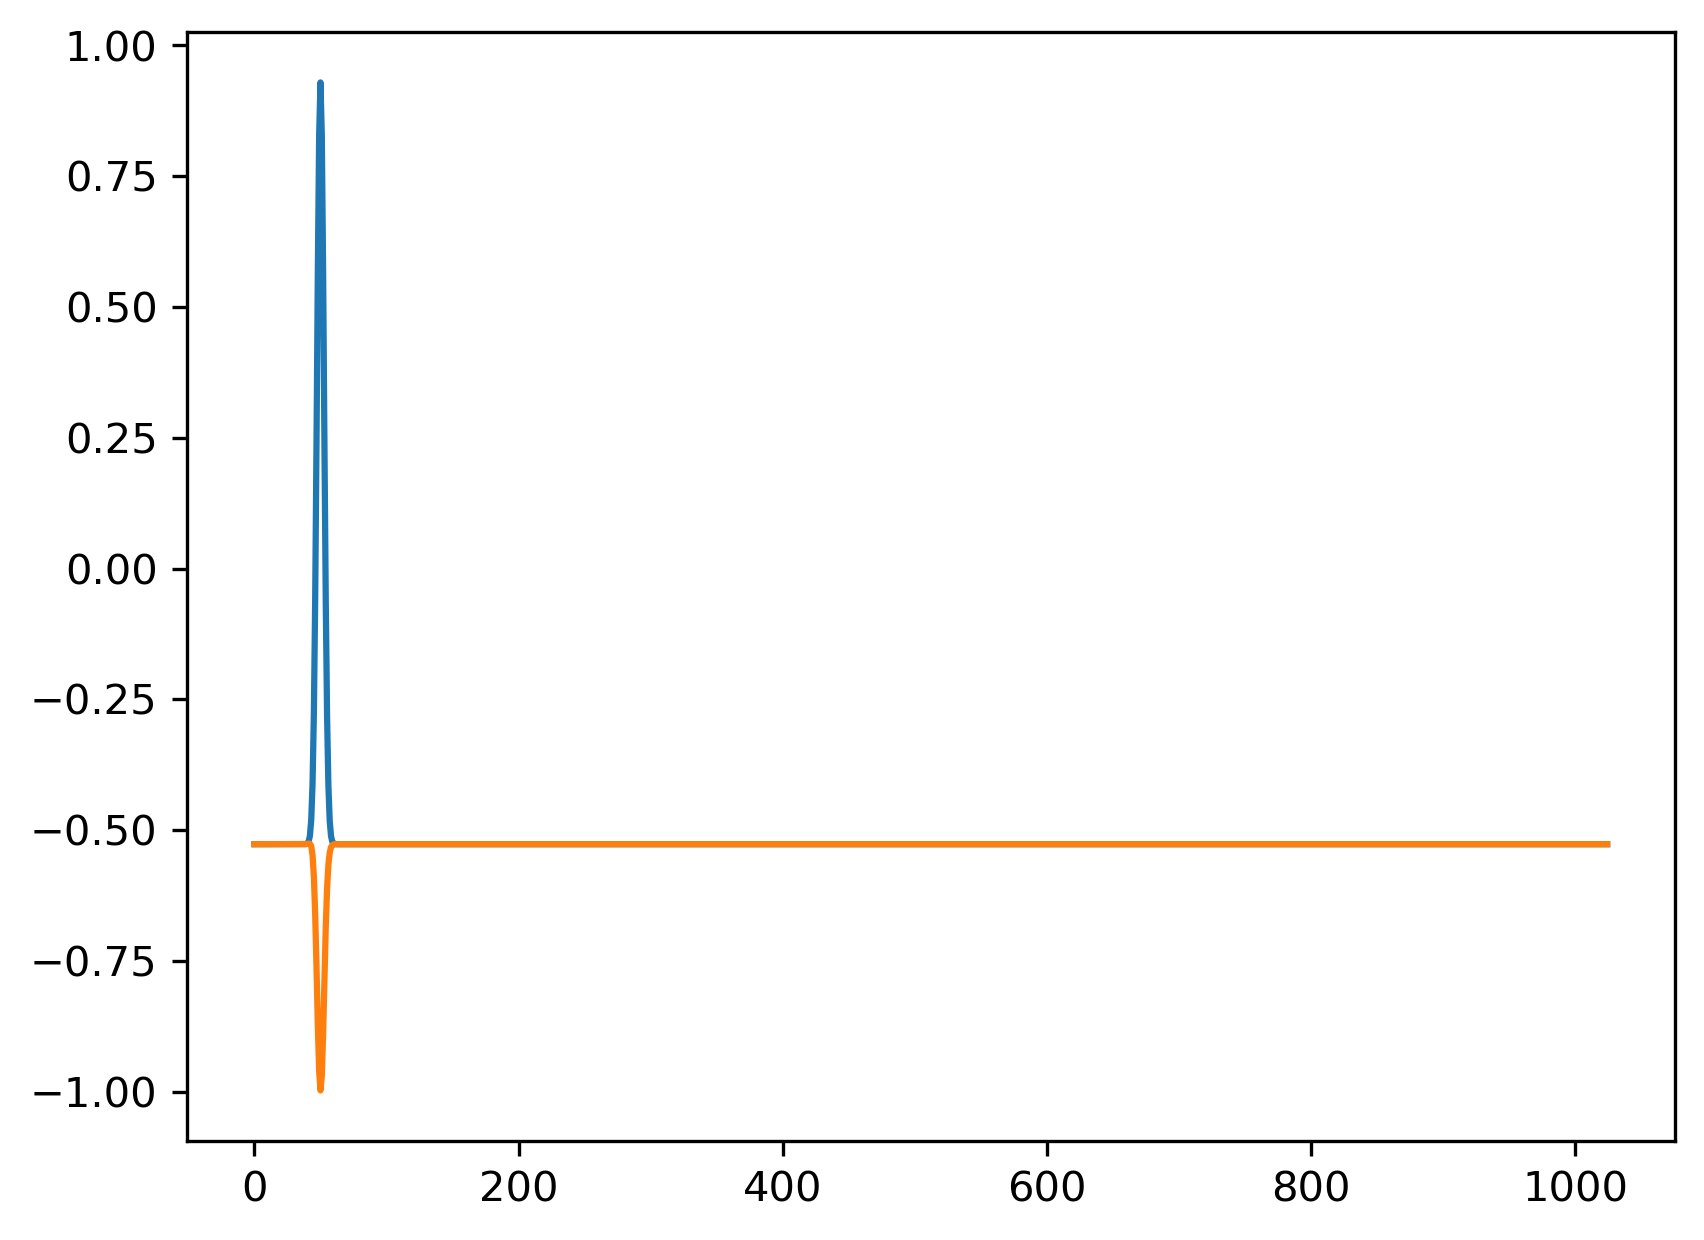

(1, 1023, 4)


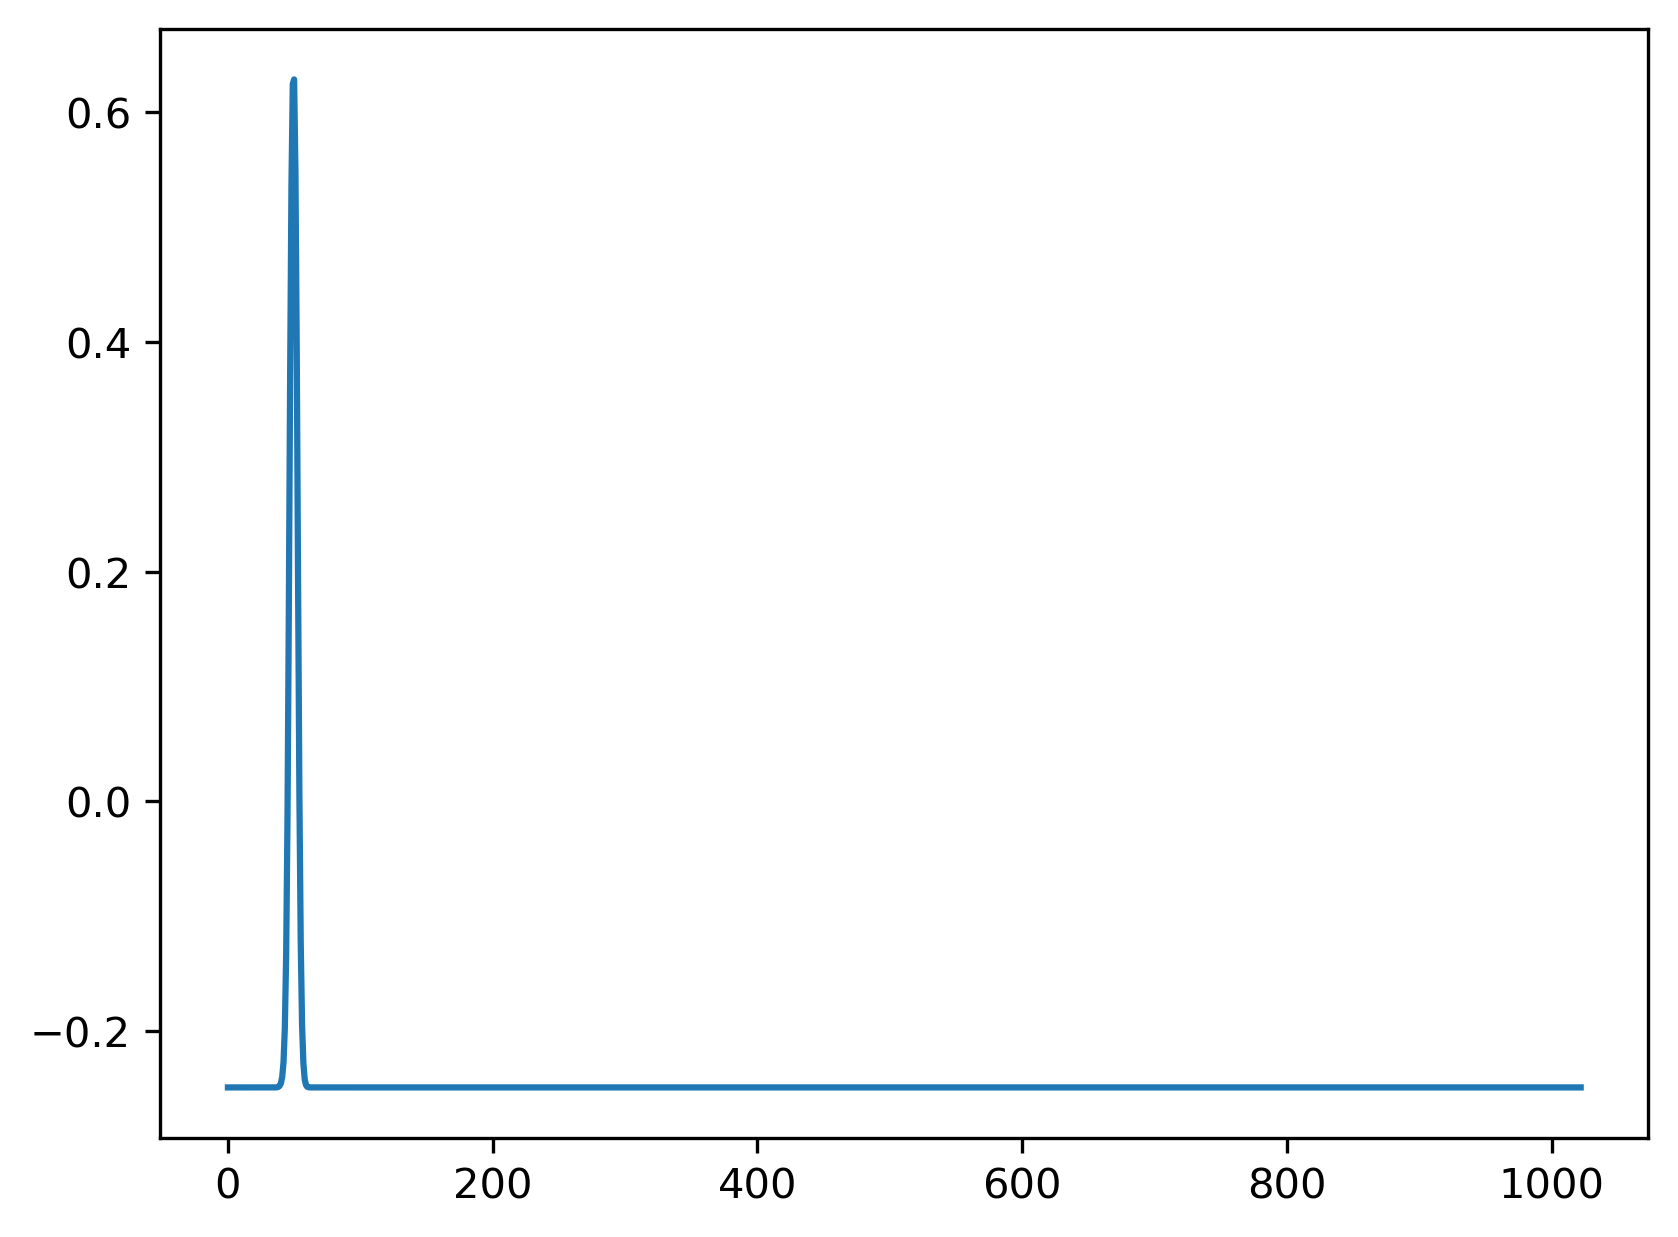

(1, 341, 4)


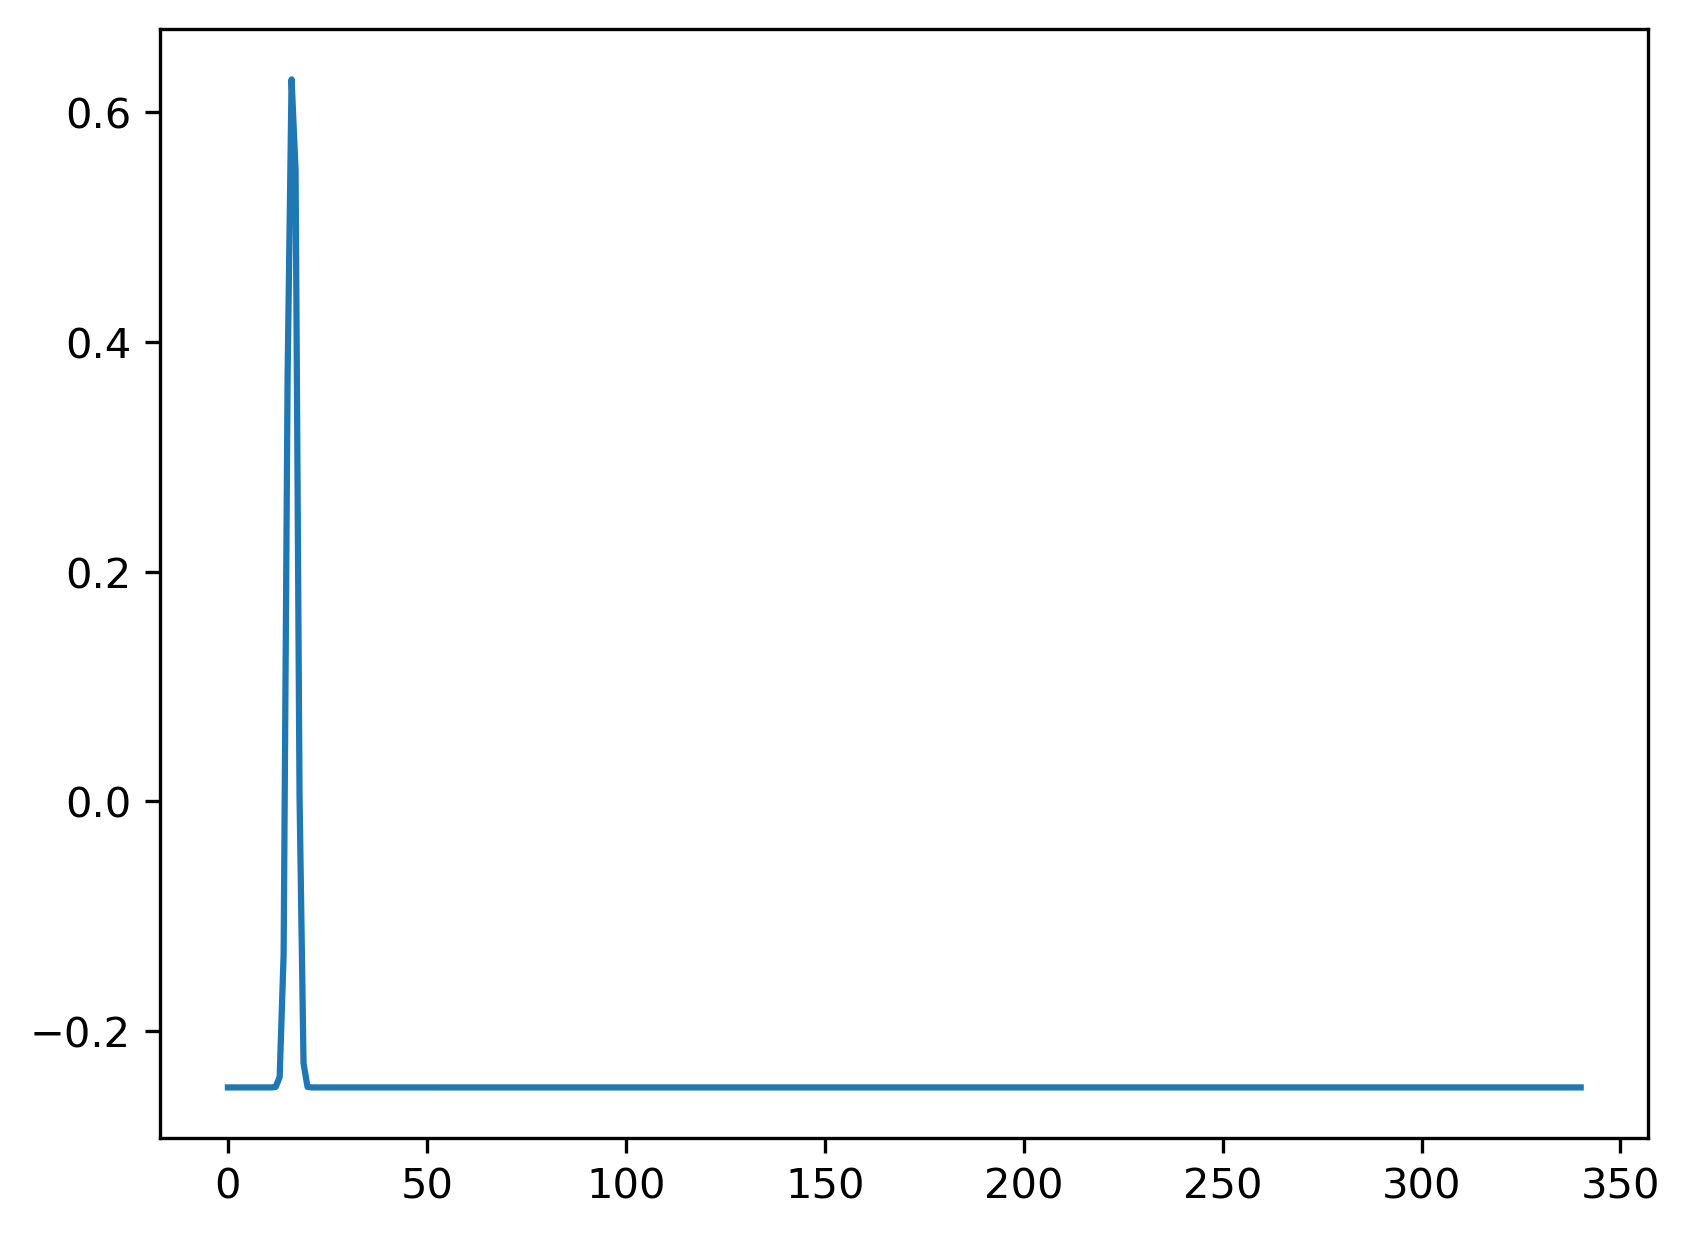

(1, 339, 8)


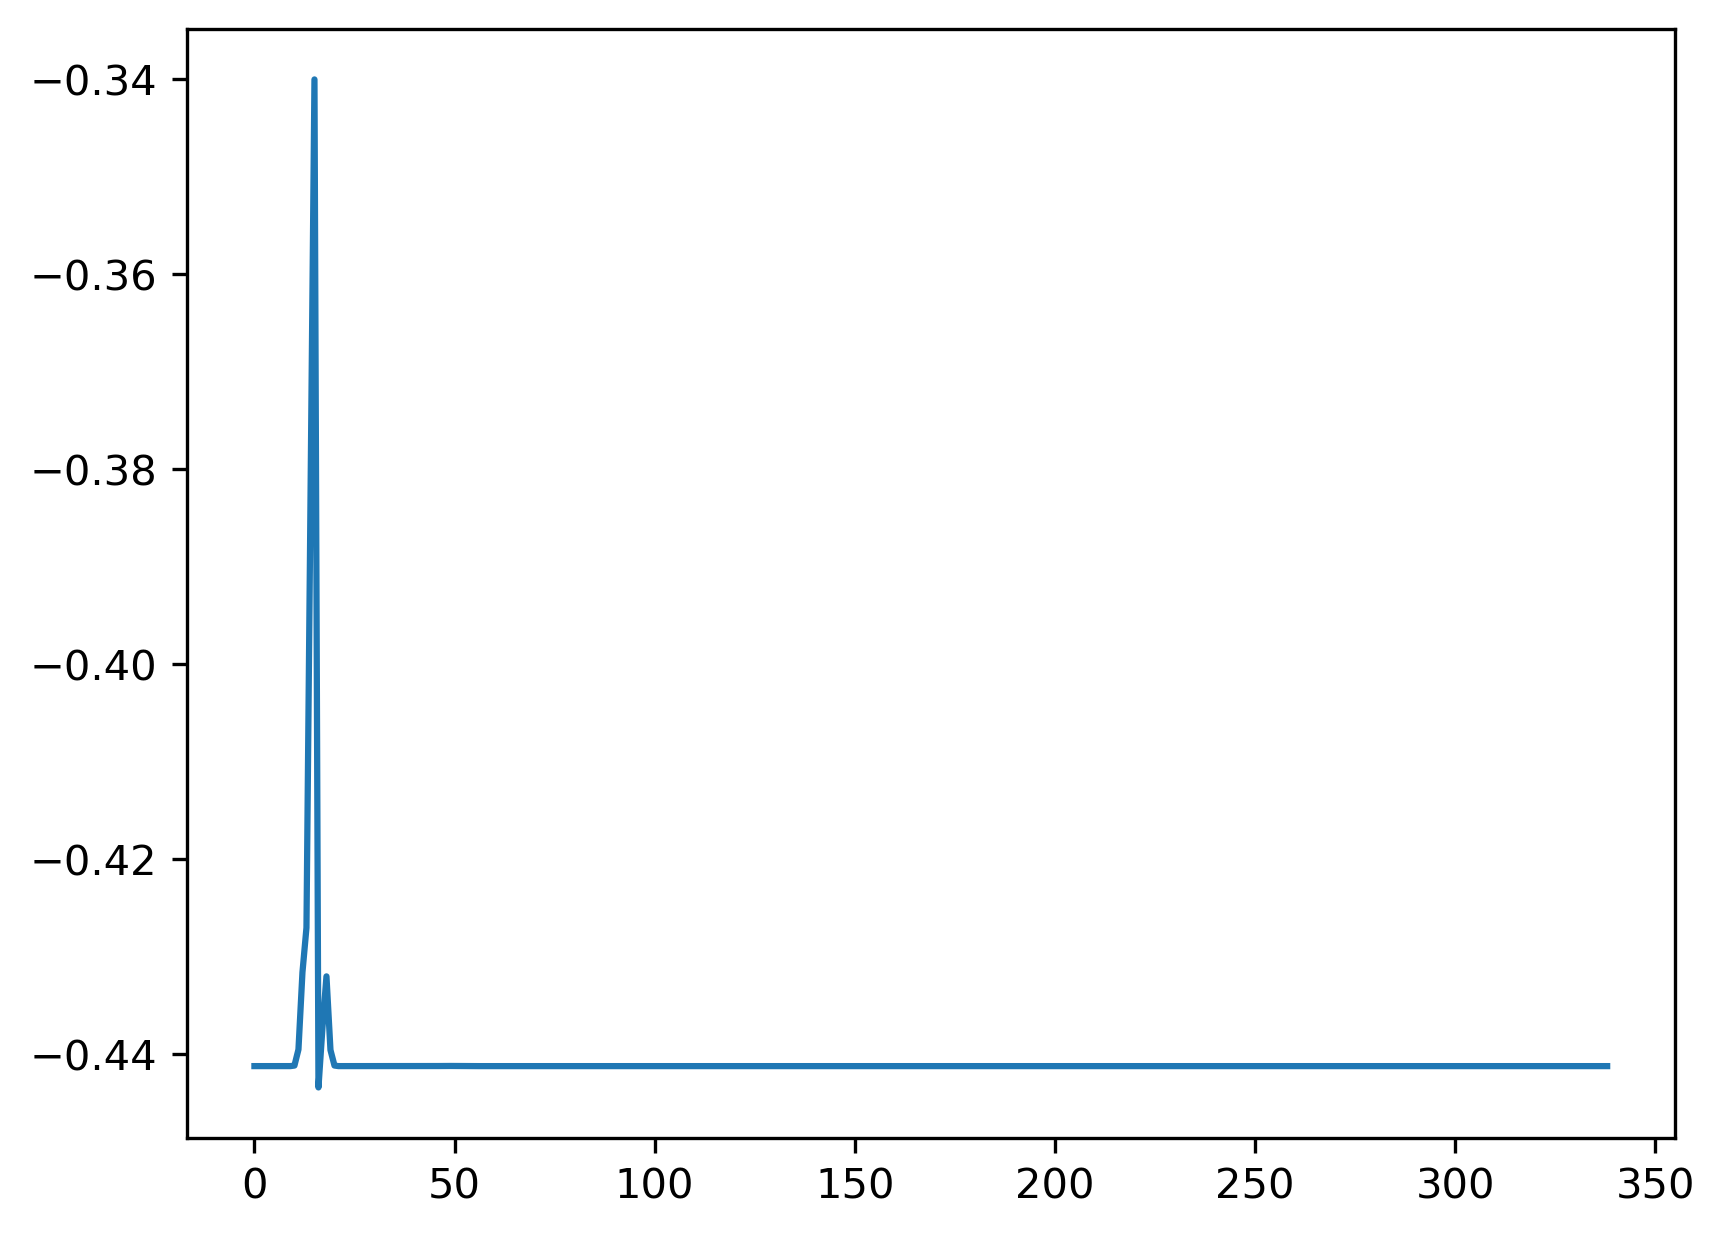

(1, 111, 16)


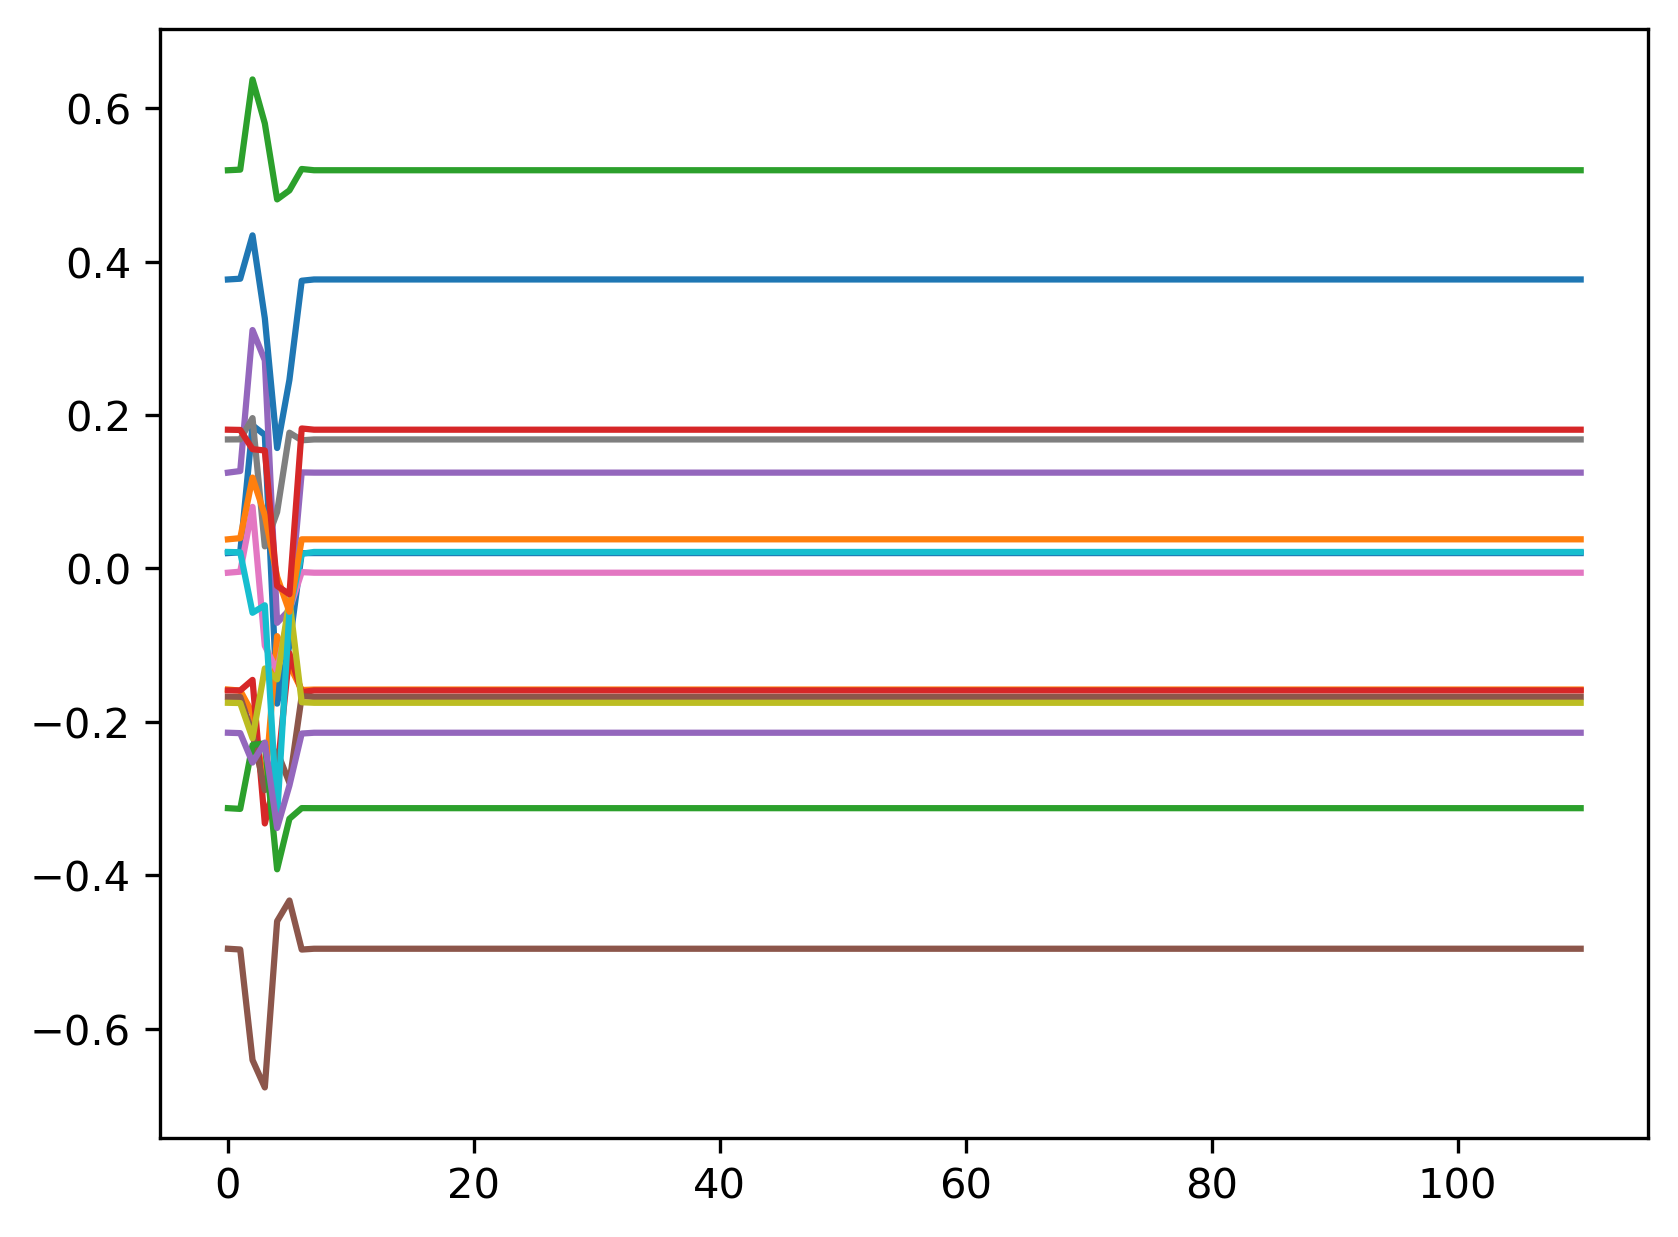

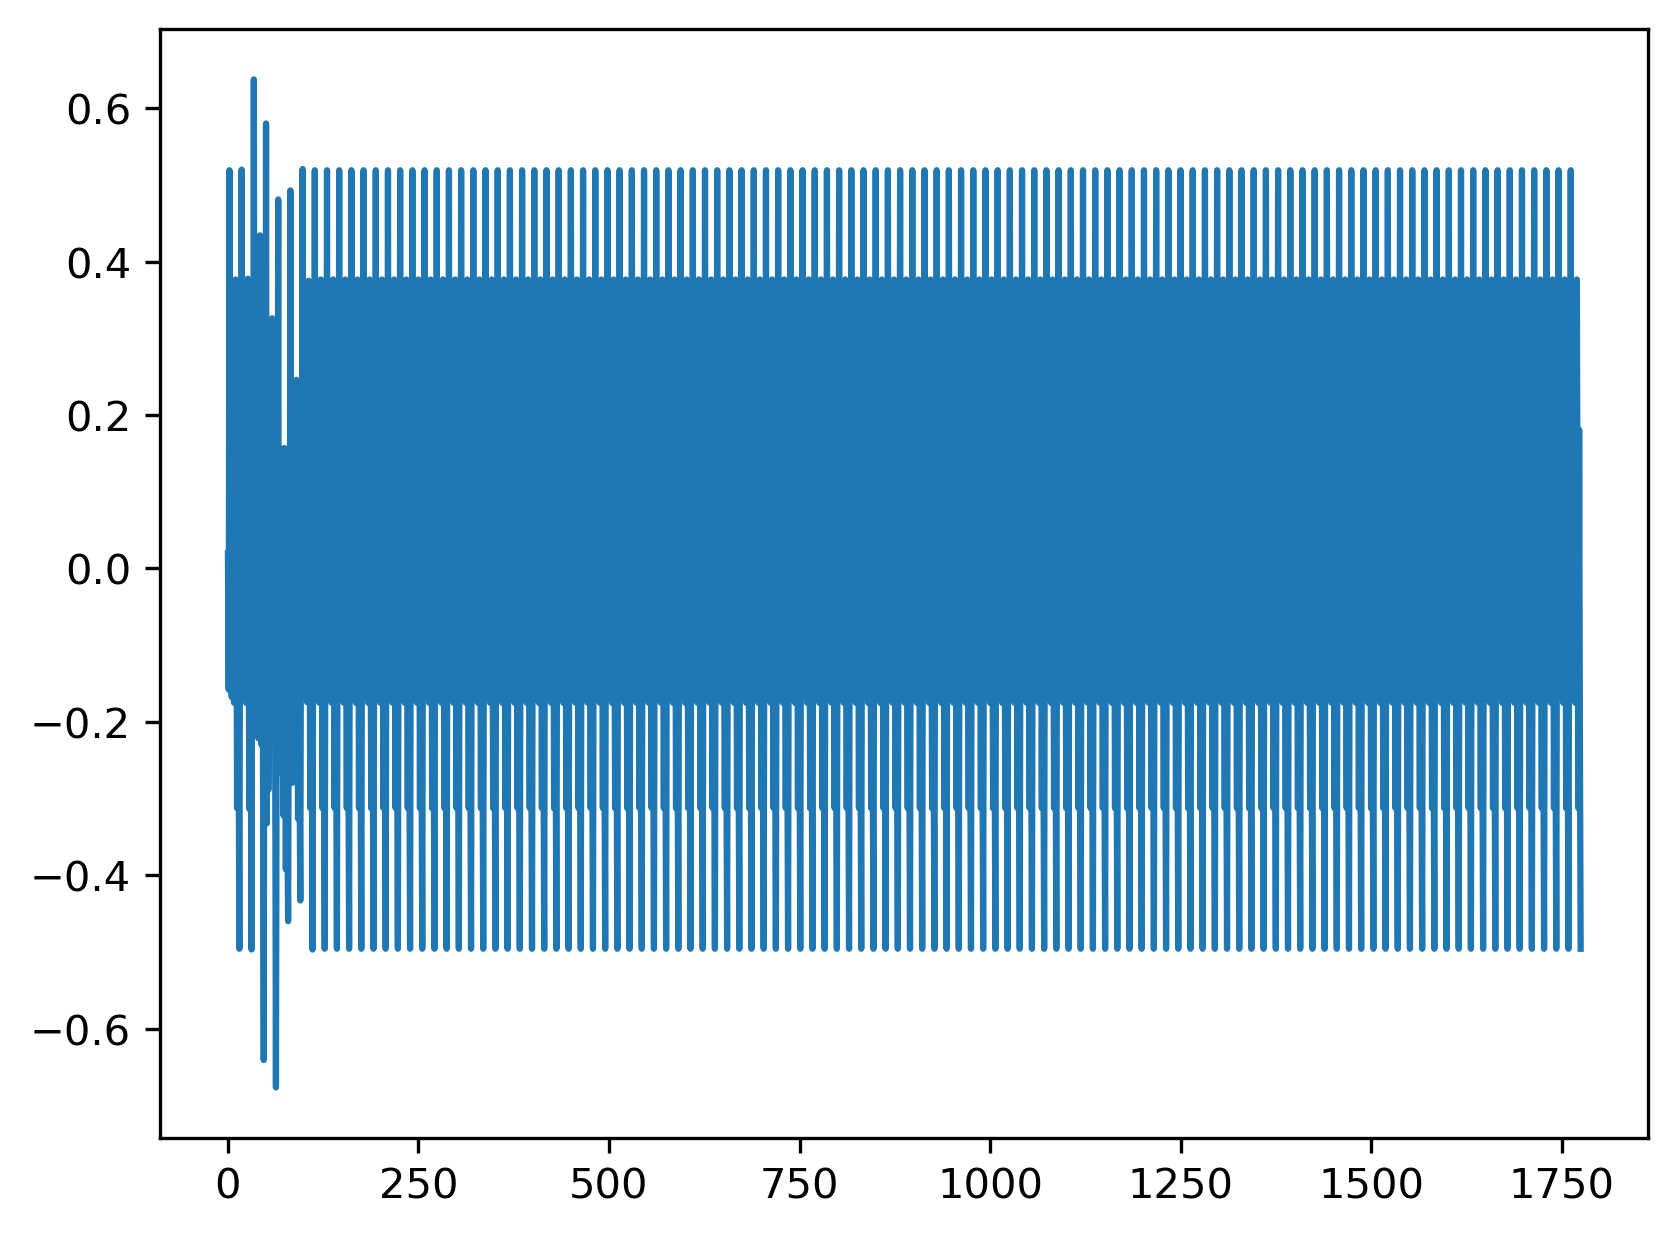

In [107]:
x = x_test_f[30]
#x = tf.expand_dims(x, axis=1)
x = tf.expand_dims(x, axis=0)
print(x.shape)

j = 1
fig = plt.figure()
fig.dpi = 300
plt.plot(x[0])
plt.show()


# Define the input shape (batch_size, time_steps, features)
input_shape = x.shape

#fig = plt.figure()
#fig.dpi = 300
#pool_layer = tf.keras.layers.MaxPool1D(3)
#x = pool_layer(x)
#print(x.shape)
#plt.plot(x[0])
#plt.show()


conv_layer = tf.keras.layers.Conv1D(filters=4, kernel_size=3, padding='valid', input_shape=input_shape, activation=tf.keras.activations.tanh)
conv_output = conv_layer(x)
print(conv_output.shape)
fig = plt.figure()
fig.dpi = 300
plt.plot(conv_output[0,:,j])
plt.show()

pool_layer = tf.keras.layers.MaxPool1D(3)
pool_output = pool_layer(conv_output)

print(pool_output.shape)
fig = plt.figure()
fig.dpi = 300
plt.plot(pool_output[0, :, j])
plt.show()

conv_layer2 = tf.keras.layers.Conv1D(filters=8, kernel_size=3, padding='valid', input_shape=input_shape, activation=tf.keras.activations.tanh)
conv_output = conv_layer2(pool_output)
print(conv_output.shape)
fig = plt.figure()
fig.dpi = 300
plt.plot(conv_output[0,:,j])
plt.show()

pool_layer = tf.keras.layers.MaxPool1D(3)
pool_output = pool_layer(conv_output)

conv_layer3 = tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='valid', input_shape=input_shape, activation=tf.keras.activations.tanh)
conv_output = conv_layer3(pool_output)
print(conv_output.shape)
#plt.plot(n_th_root(conv_output[0,:,1], 1))
fig = plt.figure()
fig.dpi = 300
plt.plot(conv_output[0,:,:])
plt.show()

#flattened_output = tf.keras.layers.Flatten(data_format = "channels_first")(conv_output)
flattened_output = tf.keras.layers.Flatten(data_format = "channels_last")(conv_output)
fig = plt.figure()
fig.dpi = 300
plt.plot(flattened_output[0])
plt.show()

## Prepare and initialize the NN-TDSE model

Here we declare our custom model which is a Tensorflow-derived Model class. The Network architecture is depicted in the figure below:

![Neural network architecture](Figures/NN.png)


We set the input shape in the first argument and the output shape in the second argument. Next we specify the dropout rate used in the MLP section and set the activation function.

Finally we build the model and print the summary.

In [83]:
reload(NN)
model = NN.TDSE_CNN((N//2+1, 2,), 2*(M//2+1), dropout=0.5, activation="tanh", conv_activation="tanh")

model.build(input_shape=(None, N//2+1, 2))

### Print summary of the model (basic info)
model.summary()

Model: "tdse_cnn_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 1000, 2)]         0         
                                                                 
 dense_132 (Dense)           multiple                  147584    
                                                                 
 dropout_110 (Dropout)       multiple                  0         
                                                                 
 dense_133 (Dense)           multiple                  8256      
                                                                 
 dropout_111 (Dropout)       multiple                  0         
                                                                 
 dense_134 (Dense)           multiple                  2080      
                                                                 
 dropout_112 (Dropout)       multiple                  

### Training and validation

In [84]:
epochs = 100
#patience = 600
patience = 20
batch_size = 64

### Compile model
model.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              #loss=TimeSpectrumMSE(),
              metrics=['mean_absolute_percentage_error'])
              #metrics=[time_spectrum_MSE])

### Fit model
history = model.fit(x_train_f, y_train_f, epochs = epochs, 
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)], batch_size=batch_size,
        validation_data=(x_test_f, y_test_f))
        #callbacks = [tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_percentage_error', patience=patience)], batch_size=batch_size)

### Quantify the accuracy of the model on the test data
model.evaluate(x_test_f, y_test_f)

Epoch 1/100


25/25 [==============================] - 4s 40ms/step - loss: 0.0118 - mean_absolute_percentage_error: 80673.8281 - val_loss: 0.0088 - val_mean_absolute_percentage_error: 44286.4258
Epoch 2/100
25/25 [==============================] - 1s 26ms/step - loss: 0.0037 - mean_absolute_percentage_error: 42927.9258 - val_loss: 0.0043 - val_mean_absolute_percentage_error: 27892.4355
Epoch 3/100
25/25 [==============================] - 1s 27ms/step - loss: 0.0016 - mean_absolute_percentage_error: 26309.9395 - val_loss: 0.0022 - val_mean_absolute_percentage_error: 18313.8633
Epoch 4/100
25/25 [==============================] - 1s 39ms/step - loss: 9.7318e-04 - mean_absolute_percentage_error: 17654.2520 - val_loss: 0.0014 - val_mean_absolute_percentage_error: 10658.6992
Epoch 5/100
25/25 [==============================] - 1s 32ms/step - loss: 6.8390e-04 - mean_absolute_percentage_error: 12729.9600 - val_loss: 8.7625e-04 - val_mean_absolute_percentage_error: 10508.8428
Epoch 6/100
25/25 [===========

[0.000635570555459708, 862.7027587890625]

### Plot the results of the TDSE-NN prediction

In [92]:
### Random indices from the validation dataset
i = 10
j = 25

### Temporal array of the output field
t_f = np.linspace(t[0], t[-1], M)

### Extract test features
features1 = (np.expand_dims(x_test_f[i],0))
### Predict the labels given the features
labels1 = model.predict(features1)[0]

### Separate real and imaginary labels
real_ = labels1[:M//2+1]
imag_ = labels1[M//2+1:]

### Reconstruct the signal from the predicted and correct labels
y_NN1 = NN.reconstruct(labels1[:M//2+1], labels1[M//2+1:], t_f)
y_orig1 = NN.reconstruct(y_test_f[i, :M//2+1], y_test_f[i, M//2+1:], t_f)

### Do the same postprocessing for the second index j
features2 = (np.expand_dims(x_test_f[j],0))
labels2 = model.predict(features2)[0]

real_ = labels2[:M//2+1]
imag_ = labels2[M//2+1:]

y_NN2 = NN.reconstruct(labels2[:M//2+1], labels2[M//2+1:], t_f)
y_orig2 = NN.reconstruct(y_test_f[j, :M//2+1], y_test_f[j, M//2+1:], t_f)


### Generate harmonic range given the sampling and number of points
freqs = fftfreq(M, t_f[1]-t_f[0])*2*np.pi/0.0568



### Plotting results
print("******************************************************************")
print("Features")
fig = plt.figure()
plt.plot(np.transpose(features1[0]).flatten(), label = "Flattened features", linewidth = 1.)
plt.plot(np.transpose(features2[0]).flatten(), label = "Flattened features", linewidth = 1.)

plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Labels")
fig = plt.figure()
plt.plot(y_test_f[i], label = "Correct labels", linestyle = "-", linewidth = 1.)
plt.plot(labels1, label = "Predicted labels")
plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Fields")
fig = plt.figure()
plt.plot(t_f, y_orig1, label = "Original", linewidth = 1.)
plt.plot(t_f, y_NN1, label = "NN prediction", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()

print("******************************************************************")
print("Fields closeup")
fig = plt.figure()
range_ = (t_f > 2700) & (t_f < 2900)
plt.plot(t_f[range_], y_orig1[range_], label = "Original", linewidth = 1.)
plt.plot(t_f[range_], y_NN1[range_], label = "NN prediction", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()

print("******************************************************************")
print("Spectra")
fig = plt.figure()
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_orig1))[0:M//2]), label = "Original 1", linewidth = 1.)
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_NN1))[0:M//2]), label = "NN prediction 1", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Phases")
fig = plt.figure()
plt.plot(freqs[0:M//2], np.unwrap(np.angle(y_test_f[j, :(M//2+1)] + 1j*(y_test_f[j, (M//2+1):])))[0:M//2], label = "Original", linewidth = 1.)
plt.plot(freqs[0:M//2], np.unwrap(np.angle(real_ + 1j*imag_))[0:M//2], label = "NN prediction", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Statistics")

fig, ax = plt.subplots()
epoch = history.epoch
ax.semilogy(epoch, (np.array(history.history['loss'])), color = 'red', linewidth = 1.)
ax.semilogy(epoch, (np.array(history.history['val_loss'])), color = 'blue', linewidth = 1.)
ax2=ax.twinx()
ax2.semilogy(epoch, (np.array(history.history['mean_absolute_percentage_error'])), color = 'red', linewidth = 1., linestyle = ":")
ax2.semilogy(epoch, (np.array(history.history['val_mean_absolute_percentage_error'])), color = 'blue', linewidth = 1., linestyle = ":")
ax.set_ylabel('Loss')
ax2.set_ylabel('Metric')
ax.set_xlabel('Epoch')
ax.legend(['train', 'validation'], loc='upper left')
ax2.legend(['train', 'validation'], loc='upper right')
fig.dpi = 300
plt.show()

1/1 [==============================] - 0s 93ms/step
******************************************************************
Features
******************************************************************
Labels
******************************************************************
Fields
******************************************************************
Fields closeup
******************************************************************
Spectra
******************************************************************
Phases
******************************************************************
Statistics


2023-11-24 15:54:42.449 python[23107:1720892] WARNING: <NSSavePanel: 0x7ff7cd6760a0> found it necessary to prepare implicitly; please prepare panels using NSSavePanel rather than NSApplication or NSWindow.
2023-11-24 15:54:43.445 python[23107:1720892] WARNING: <NSSavePanel: 0x7ff7cd6760a0> found it necessary to start implicitly; please start panels using NSSavePanel rather than NSApplication or NSWindow.
2023-11-24 15:54:43.445 python[23107:1720892] WARNING: <NSSavePanel: 0x7ff7cd6760a0> running implicitly; please run panels using NSSavePanel rather than NSApplication.


# Low Intensity field

Same approach but for low-intensity dataset.

The dataset contains 2001 HDF5 files (500 iterations of RK4). The total spatially resolved harmonic spectrum during the propagation is shown in the figure below:


![High-intensity field](./Figures/1e10_ab-initio_full_prop_LQ.png)

In [2]:
dataset, t = NN.load_fields_from_h5("/Volumes/NEMEC_SSD/1e10_dz=50000/")


In [3]:
print(dataset.shape)
np.random.shuffle(dataset)
print(dataset.shape)

(4001, 2, 25601)
(4001, 2, 25601)


In [4]:
N = 1025
M = 1025
f = NN.filter(np.ones((len(t))), t)

xf = np.array([np.transpose(NN.preprocess(f*x, N, t)) for x in dataset[:,0]])
yf = np.array([np.concatenate(NN.preprocess(f*(-y[1]-1*y[0]), M, t), axis = None) for y in dataset])

In [83]:
x_train_f, x_test_f = xf[:3200], xf[3200:4000]
y_train_f, y_test_f = yf[:3200], yf[3200:4000]


In [84]:
x_train_f, x_test_f = NN.min_max_normalize(x_train_f, x_test_f)

In [88]:
model_final = NN.TDSE_CNN((N//2+1, 2,), 2*(M//2+1), dropout=0.5, activation="tanh", conv_activation="tanh")

#model_1000.build(input_shape=(None, N//2+1, 2))
#model_2000.build(input_shape=(None, N//2+1, 2))
#model_4000.build(input_shape=(None, N//2+1, 2))
model_final.build(input_shape=(None, N//2+1, 2))

### Print summary of the model (basic info)
#model_1000.summary()
#model_2000.summary()
#model_4000.summary()
model_final.summary()

Model: "tdse_cnn_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 513, 2)]          0         
                                                                 
 dense_24 (Dense)            multiple                  73856     
                                                                 
 dropout_20 (Dropout)        multiple                  0         
                                                                 
 dense_25 (Dense)            multiple                  8256      
                                                                 
 dropout_21 (Dropout)        multiple                  0         
                                                                 
 dense_26 (Dense)            multiple                  2080      
                                                                 
 dropout_22 (Dropout)        multiple                  0

In [89]:
epochs = 100
#patience = 600
patience = 25
batch_size = 64

### Compile model
model_final.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#model_1000.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#model_2000.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
#model_4000.compile(#optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mean_absolute_percentage_error'])

### Fit model
history_final = model_final.fit(x_train_f, y_train_f, epochs = epochs, 
#history_1000 = model_1000.fit(x_train_f, y_train_f, epochs = epochs, 
#history_2000 = model_2000.fit(x_train_f, y_train_f, epochs = epochs, 
#history_4000 = model_4000.fit(x_train_f, y_train_f, epochs = epochs, 
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)], batch_size=batch_size,
        validation_data=(x_test_f, y_test_f))

### Quantify the accuracy of the model on the test data
model_final.evaluate(x_test_f, y_test_f)
#model_1000.evaluate(x_test_f, y_test_f)
#model_2000.evaluate(x_test_f, y_test_f)
#model_4000.evaluate(x_test_f, y_test_f)

Epoch 1/100
50/50 [==============================] - 14s 90ms/step - loss: 0.0135 - mean_absolute_percentage_error: 82587784.0000 - val_loss: 0.0026 - val_mean_absolute_percentage_error: 39059928.0000
Epoch 2/100
50/50 [==============================] - 4s 71ms/step - loss: 0.0022 - mean_absolute_percentage_error: 34005044.0000 - val_loss: 7.8867e-04 - val_mean_absolute_percentage_error: 21252570.0000
Epoch 3/100
50/50 [==============================] - 3s 69ms/step - loss: 7.1237e-04 - mean_absolute_percentage_error: 19617764.0000 - val_loss: 2.5982e-04 - val_mean_absolute_percentage_error: 12173285.0000
Epoch 4/100
50/50 [==============================] - 3s 64ms/step - loss: 3.0097e-04 - mean_absolute_percentage_error: 12718368.0000 - val_loss: 8.2940e-05 - val_mean_absolute_percentage_error: 6848541.5000
Epoch 5/100
50/50 [==============================] - 3s 68ms/step - loss: 1.4075e-04 - mean_absolute_percentage_error: 8695027.0000 - val_loss: 2.7454e-05 - val_mean_absolute_perce

[2.288998157684574e-11, 2.0581836700439453]

### Plot results

In [ ]:
#model = model_1000
#model = model_2000
#model = model_4000
model = model_final
#history = history_1000
#history = history_2000
#history = history_4000
history = history_final


i = 10
j = 55


t_f = np.linspace(t[0], t[-1], M)

### Features and labels for index i
features1 = (np.expand_dims(x_test_f[i],0))
labels1 = model.predict(features1)[0]

real_ = labels1[:M//2+1]
imag_ = labels1[M//2+1:]

y_NN1 = NN.reconstruct(labels1[:M//2+1], labels1[M//2+1:], t_f)
y_orig1 = NN.reconstruct(y_test_f[i, :M//2+1], y_test_f[i, M//2+1:], t_f)

features2 = (np.expand_dims(x_test_f[j],0))
labels2 = model.predict(features2)[0]


### Features and labels for index j
real_ = labels2[:M//2+1]
imag_ = labels2[M//2+1:]
y_NN2 = NN.reconstruct(labels2[:M//2+1], labels2[M//2+1:], t_f)
y_orig2 = NN.reconstruct(y_test_f[j, :M//2+1], y_test_f[j, M//2+1:], t_f)

### Generate harmonic range
freqs = fftfreq(M, t_f[1]-t_f[0])*2*np.pi/0.0568


print("******************************************************************")
print("Features")
fig = plt.figure()
plt.plot(np.transpose(features1[0]).flatten(), label = "Flattened features", linewidth = 1.)
plt.plot(np.transpose(features2[0]).flatten(), label = "Flattened features", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Labels")
fig = plt.figure()
plt.plot(y_test_f[i], label = "Original labels", linestyle = "-", linewidth = 1.)
plt.plot(y_test_f[j], label = "Original labels", linestyle = "-", linewidth = 1.)
plt.plot(labels1, label = "Predicted labels via NN")
plt.plot(labels2, label = "Predicted labels via NN")
plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Fields")
fig = plt.figure()
plt.plot(t_f, y_orig1, label = "Original", linewidth = 1.)
plt.plot(t_f, y_NN1, label = "NN prediction", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()

print("******************************************************************")
print("Fields closeup")
fig = plt.figure()
range_ = (t_f > 2700) & (t_f < 2900)
plt.plot(t_f[range_], y_orig1[range_], label = "Original", linewidth = 1.)
plt.plot(t_f[range_], y_NN1[range_], label = "NN prediction", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()

print("******************************************************************")
print("Spectra")
fig = plt.figure()
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_orig1))[0:M//2]), label = "Original 1", linewidth = 1.)
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_NN1))[0:M//2]), label = "NN prediction 1", linewidth = 1.)


plt.semilogy(freqs[0:M//2], (np.abs(fft(y_orig2))[0:M//2]), label = "Original 2", linewidth = 1.)
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_NN2))[0:M//2]), label = "NN prediction 2", linewidth = 1.)

plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Phases")
fig = plt.figure()
plt.plot(freqs[0:M//2], np.unwrap(np.angle(y_test_f[j, :(M//2+1)] + 1j*(y_test_f[j, (M//2+1):])))[0:M//2], label = "Original", linewidth = 1.)
plt.plot(freqs[0:M//2], np.unwrap(np.angle(real_ + 1j*imag_))[0:M//2], label = "NN prediction", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Statistics")

fig, ax = plt.subplots()
epoch = history.epoch
ax.semilogy(epoch, (np.array(history.history['val_loss'])), color = 'blue', linewidth = 1.)
ax.semilogy(epoch, (np.array(history.history['loss'])), color = 'red', linewidth = 1.)
ax2=ax.twinx()
ax2.semilogy(epoch, (np.array(history.history['mean_absolute_percentage_error'])), color = 'blue', linewidth = 1., linestyle = ":")
ax2.semilogy(epoch, (np.array(history.history['val_mean_absolute_percentage_error'])), color = 'red', linewidth = 1., linestyle = ":")
ax.set_ylabel('Loss')
ax2.set_ylabel('Metric')
ax.set_xlabel('Epoch')
ax.legend(['train', 'validation'], loc='upper left')
ax2.legend(['train', 'validation'], loc='upper right')
fig.dpi = 300
plt.show()

### Plot results for different number of datasets

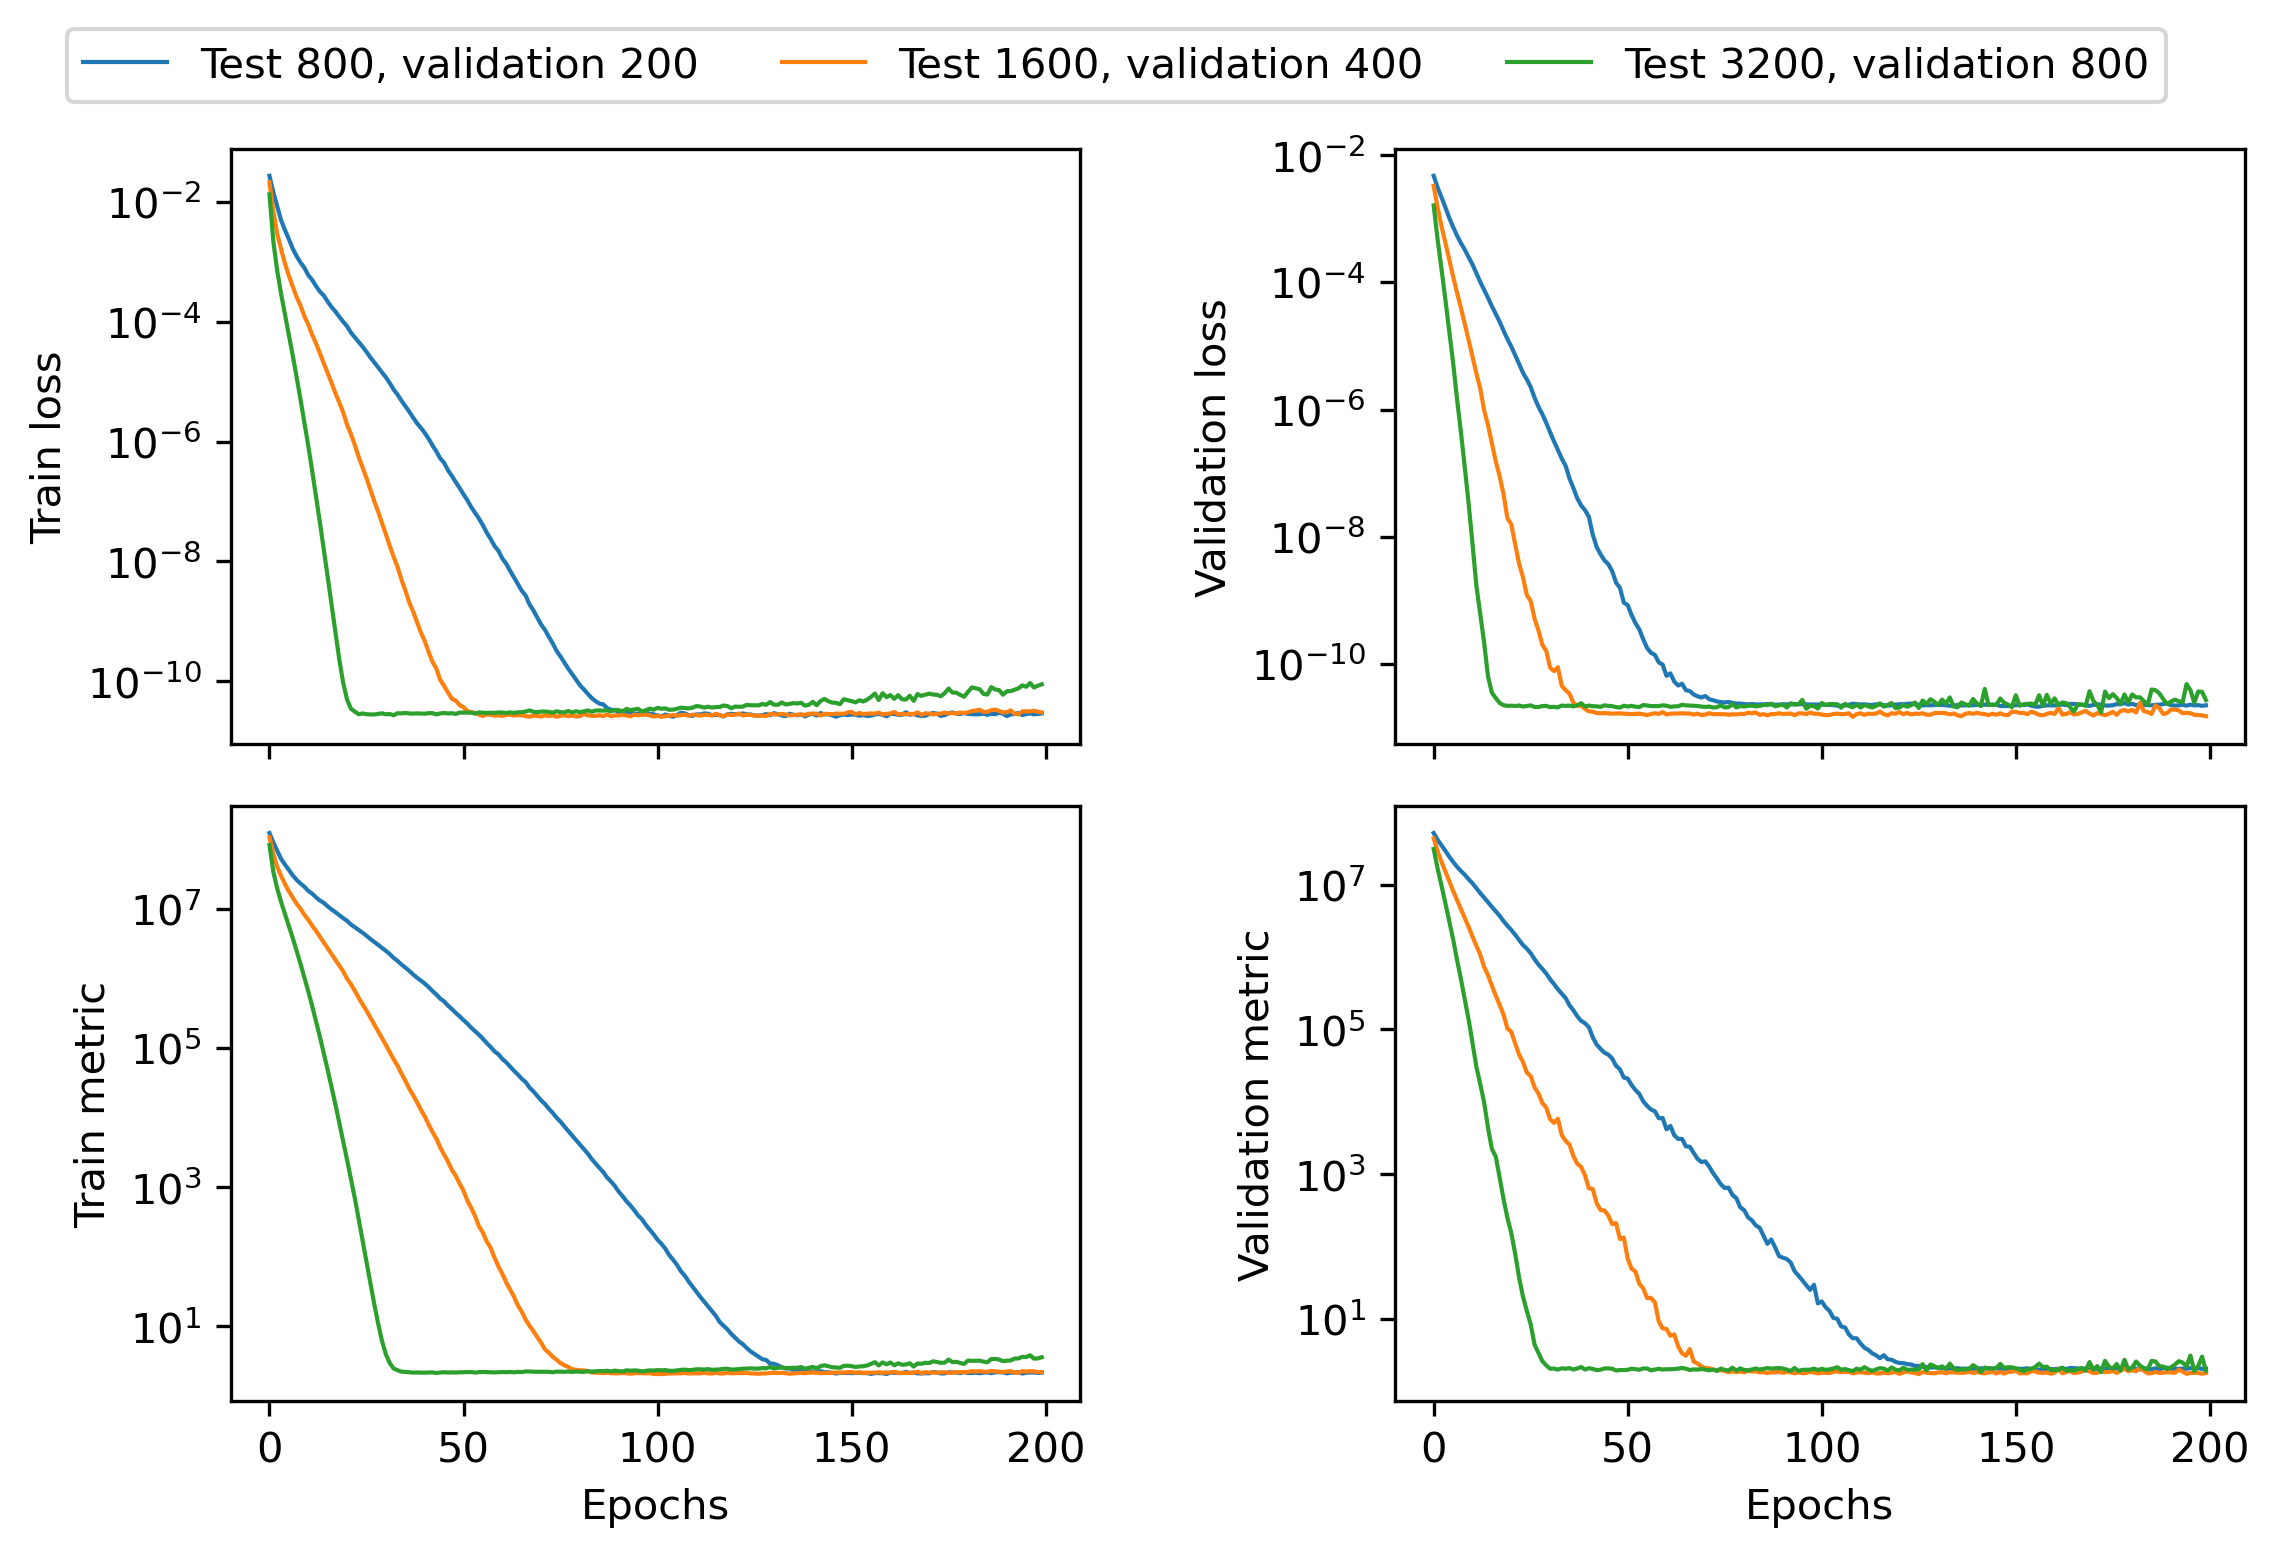

In [24]:

fig, ax = plt.subplots(2,2, sharex=True)
epoch = history_1000.epoch


ax[0, 0].semilogy(epoch, (np.array(history_1000.history['loss'])), linewidth = 1.)
ax[0, 0].semilogy(epoch, (np.array(history_2000.history['loss'])), linewidth = 1.)
ax[0, 0].semilogy(epoch, (np.array(history_4000.history['loss'])), linewidth = 1.)
ax[0, 1].semilogy(epoch, (np.array(history_1000.history['val_loss'])), linewidth = 1., label = "Test 800, validation 200")
ax[0, 1].semilogy(epoch, (np.array(history_2000.history['val_loss'])), linewidth = 1., label = "Test 1600, validation 400")
ax[0, 1].semilogy(epoch, (np.array(history_4000.history['val_loss'])), linewidth = 1., label = "Test 3200, validation 800")
#ax2=ax[0].twinx()
ax[1, 0].semilogy(epoch, (np.array(history_1000.history['mean_absolute_percentage_error'])), linewidth = 1.)
ax[1, 0].semilogy(epoch, (np.array(history_2000.history['mean_absolute_percentage_error'])), linewidth = 1.)
ax[1, 0].semilogy(epoch, (np.array(history_4000.history['mean_absolute_percentage_error'])), linewidth = 1.)
ax[1, 1].semilogy(epoch, (np.array(history_1000.history['val_mean_absolute_percentage_error'])), linewidth = 1.)
ax[1, 1].semilogy(epoch, (np.array(history_2000.history['val_mean_absolute_percentage_error'])), linewidth = 1.)
ax[1, 1].semilogy(epoch, (np.array(history_4000.history['val_mean_absolute_percentage_error'])), linewidth = 1.)


ax[0, 0].set_ylabel('Train loss')
ax[0, 1].set_ylabel('Validation loss')
ax[1, 0].set_ylabel('Train metric')
ax[1, 0].set_xlabel('Epochs')
ax[1, 1].set_ylabel('Validation metric')
ax[1, 1].set_xlabel('Epochs')

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels, loc="upper center", ncol = 3,bbox_to_anchor = (0, 0.05, 1, 1))

plt.tight_layout()
fig.dpi = 300
fig.set_size_inches((8,5))
plt.savefig("res.pdf", bbox_inches="tight")
plt.show()


Models comparison on single data

1/1 [==============================] - 0s 46ms/step
******************************************************************
Fields


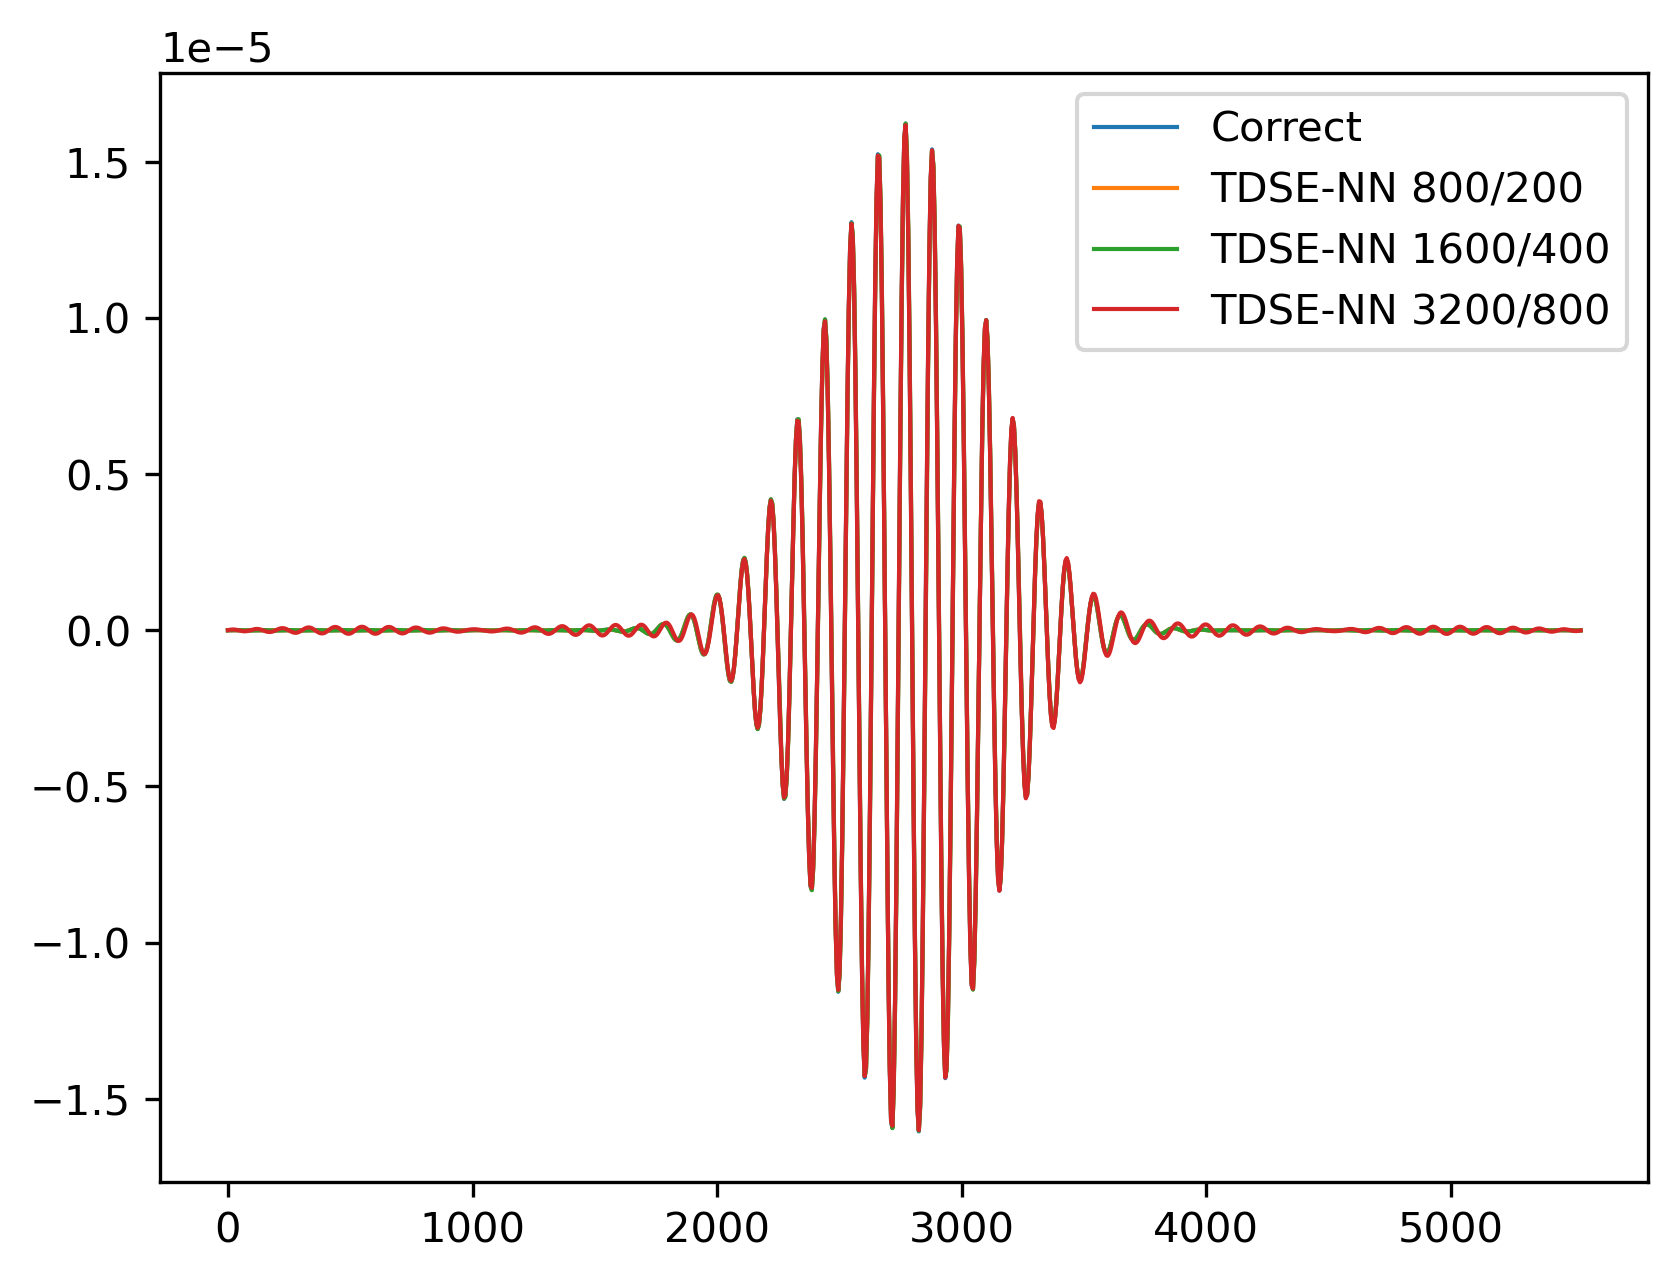

******************************************************************
Spectra


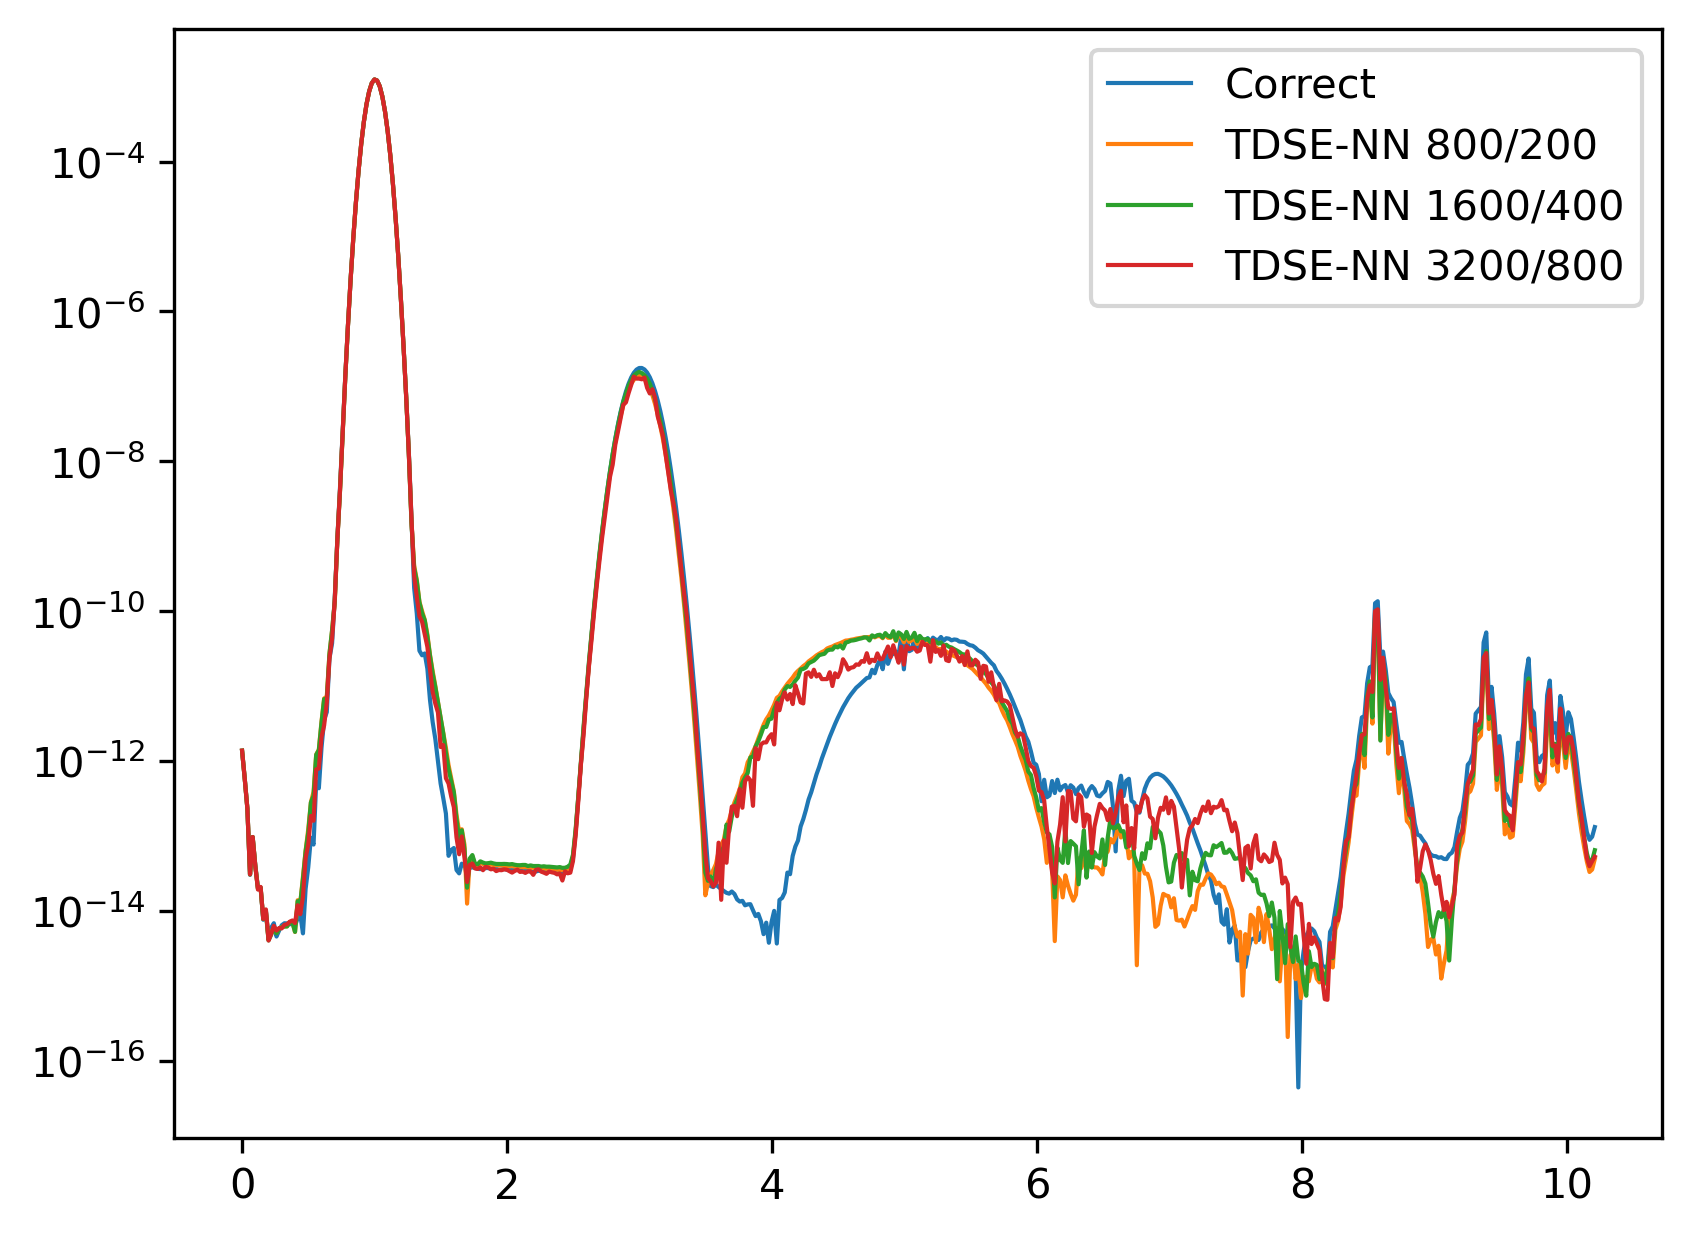

In [54]:
%matplotlib inline


i = 10
j = 55

t_f = np.linspace(t[0], t[-1], M)

features1 = (np.expand_dims(x_test_f[i],0))
labels1000 = model_1000.predict(features1)[0]
labels2000 = model_2000.predict(features1)[0]
labels4000 = model_4000.predict(features1)[0]


y_NN1 = NN.reconstruct(labels1000[:M//2+1], labels1000[M//2+1:], t_f)
y_NN2 = NN.reconstruct(labels2000[:M//2+1], labels2000[M//2+1:], t_f)
y_NN3 = NN.reconstruct(labels4000[:M//2+1], labels4000[M//2+1:], t_f)
y_orig1 = NN.reconstruct(y_test_f[i, :M//2+1], y_test_f[i, M//2+1:], t_f)


freqs = fftfreq(M, t_f[1]-t_f[0])*2*np.pi/0.0568


print("******************************************************************")
print("Fields")
fig = plt.figure()
plt.plot(t_f, y_orig1, label = "Correct", linewidth = 1.)
plt.plot(t_f, y_NN1, label = "TDSE-NN 800/200", linewidth = 1.)
plt.plot(t_f, y_NN2, label = "TDSE-NN 1600/400", linewidth = 1.)
plt.plot(t_f, y_NN3, label = "TDSE-NN 3200/800", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()


print("******************************************************************")
print("Spectra")
fig = plt.figure()
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_orig1))[0:M//2]), label = "Correct", linewidth = 1.)
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_NN1))[0:M//2]), label = "TDSE-NN 800/200", linewidth = 1.)
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_NN2))[0:M//2]), label = "TDSE-NN 1600/400", linewidth = 1.)
plt.semilogy(freqs[0:M//2], (np.abs(fft(y_NN3))[0:M//2]), label = "TDSE-NN 3200/800", linewidth = 1.)
plt.legend()
fig.dpi = 300
plt.show()